### Fashion MNIST & IRIS 모델 구현
- Fashion MNIST 모델 
    - 옷 판별 모델 구현
    

- 모델 구현 과정
    - 데이터 전처리 (결측치, 이상치, 중복치 처리 등등)
    - 학습 모델 설계 (모델 인스턴스 생성 + forward 메서드)
    - 데이터셋 모델 설계 (모델 인스턴스 생성 + 배치수 만큼 텐서화 진행)
    - 데이터 분리, 인코딩, 스케일링
    - 최적화, 손실함수 인스턴스 정하기
    - 만든 모델을 바탕으로 학습 진행  
        (데이터 로딩 -> 학습 -> 손실 -> 평가 -> 최적화-> 검증 및 결과 저장)

In [149]:
from urllib.request import urlretrieve  #(데이터 불러오는 모듈)
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchmetrics import F1Score
from torchmetrics.classification import MulticlassF1Score, MulticlassConfusionMatrix
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt
from func import Torch_preccesing



[1] 데이터 전처리 <hr>

In [150]:
# 데이터 불러오기
# TEST_URL  = 'https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_test.csv'
# TRAIN_URL = 'https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_train.csv'

TRAIN_FILE = './data/fashion-mnist_train.csv'
TEST_FILE  = './data/fashion-mnist_test.csv'
# # 데이터 파일로 저장
# urlretrieve(TRAIN_URL, TRAIN_FILE)   #url에 있는 파일을 지정 경로에 저장
# urlretrieve(TEST_URL, TEST_FILE)

In [151]:
trainDF= pd.read_csv(TRAIN_FILE)
testDF= pd.read_csv(TEST_FILE)
# 사진 데이터 이므로 결측치, 이상치, 중복치 처리 X


In [152]:
trainDF.columns[:1]

Index(['label'], dtype='object')

In [153]:
# 피쳐/타겟 분리
trainF= trainDF[trainDF.columns[1:]]
trainT= trainDF[trainDF.columns[:1]]
testF= testDF[testDF.columns[1:]]
testT=testDF[testDF.columns[:1]]
print(trainF.columns, trainT.columns, testF.columns, testT.columns)

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784) Index(['label'], dtype='object') Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784) Index(['label'], dtype='object')


In [154]:
# 피쳐: pixel 1 ~ 784  (784 컬럼)
# 타겟: label (0~9 10가지)

[2] 모델 데이터 설계
- 클래스 목적: Fashion 데이터 학습 및 추론
- 클래스 이름: FashionMClf
- 부모 클래스: nn.Module()
- 매개변수: 입출력 개수, AF, 마지막 출력 AF, 은닉층의 수

- 구조 설정
    - 입력층: 784 -> 20, AF= Relu
    - 은닉층: 20 -> 30, AF= Relu, 3층
    - 출력층: 30 -> 라벨 컬럼 수(10), softMAX인데, Cross Entropy 사용시 필요 없음

In [155]:
class get_classification_model(nn.Module):
    '''
    은닉층 수= 리스트 수-1
    '''
    def __init__(self, in_in, out_out, h_in, h_out) -> None:
        super().__init__()
        self.in_layer= nn.Linear(in_in, h_in)
        self.h_layer=nn.Linear(h_in, h_out)
        self.h_layer2=nn.Linear(h_out, h_out)
        self.out_layer= nn.Linear(h_out, out_out)
    
    def forward(self, input_data):
       y=self.in_layer(input_data)
       y=F.relu(y)

       y=self.h_layer(y)
       y= F.relu(y)
       y=self.h_layer2(y)
       y= F.relu(y)
       
       return self.out_layer(y)
        


In [156]:
# 모델 테스트
model= get_classification_model(in_in=784, out_out=10, h_in=150, h_out=100)
print(model)
summary(model, input_size=(60000, 784)) #행과 열

get_classification_model(
  (in_layer): Linear(in_features=784, out_features=150, bias=True)
  (h_layer): Linear(in_features=150, out_features=100, bias=True)
  (h_layer2): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
get_classification_model                 [60000, 10]               --
├─Linear: 1-1                            [60000, 150]              117,750
├─Linear: 1-2                            [60000, 100]              15,100
├─Linear: 1-3                            [60000, 100]              10,100
├─Linear: 1-4                            [60000, 10]               1,010
Total params: 143,960
Trainable params: 143,960
Non-trainable params: 0
Total mult-adds (G): 8.64
Input size (MB): 188.16
Forward/backward pass size (MB): 172.80
Params size (MB): 0.58
Estimated Total Size (MB): 361.54

[3] 데이터셋 클래스 설계
- 피쳐: 784개
- 타겟: 10개(인코딩)
- 클래스 이름: FashionDataset
- 부모 클래스: untils.data.Dataset
- 속성/필드: feature, target, nrows, n_features
- 필수 메서드 오버라이딩
    - init
    - len
    - getitem

In [157]:
class CustomDataset(Dataset):
    def __init__(self, featureDF, targetDF) -> None:
        super().__init__()
        self.featureDF= featureDF
        self.targetDF= targetDF
        self.n_rows= featureDF.shape[0]
        self.n_features= featureDF.shape[1]
    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        featureTS= torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS= torch.FloatTensor(self.targetDF.iloc[index].values)
        return featureTS, targetTS
    

[4] 학습 준비


In [158]:
# 랜덤 고정
torch.manual_seed(1)

# 텐서 저장 및 실행 위치 설정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

# 모델 인스턴스
h_layer=[200,150]
model= get_classification_model(in_in=784, out_out=10, h_in=300, h_out=150)

In [159]:
# 설정값
EPOCH= 250
BATCH_SIZE=32
LR=0.001

In [160]:
trainDS= CustomDataset(trainF, trainT)
testDS=CustomDataset(testF, testT)
trainDL= DataLoader(trainDS, batch_size=32)
testDL= DataLoader(testDS, batch_size=BATCH_SIZE)

In [161]:
# DL 테스트
for f, t in trainDL:
    print(f.shape, t.shape)
    break
len(trainDL)

torch.Size([32, 784]) torch.Size([32, 1])


1875

In [162]:
# 최적화 인스턴스 사용할 최적화 모델 이름(모델 파라미터, 단계)
optimizer= optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 -> 다중분류
MCLfLoss= nn.CrossEntropyLoss()


In [163]:
len(trainDS)

60000

[5] 학습 진행

In [164]:
# 손실, 평가값 저장
LOSS_HISTORY, SCORE_HISTORY= [[],[]], [[],[]]
for epoch in range(EPOCH):
    print(f'{epoch+1}/{EPOCH}')
    model.train()
    loss_total, score_total= 0,0
    loss_val_total, score_val_total=0,0

    for train_feature, train_target in trainDL:
        # 학습
        pre_y=model(train_feature)

        # 손실
        loss= MCLfLoss(pre_y, train_target.reshape(-1).long())
        loss_total+=loss.item()

        # 평가
        score= MulticlassF1Score(num_classes=10)(pre_y, train_target.reshape(-1))
        score_total+=score.item()
        # 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 검증

    model.eval()
    with torch.no_grad():
        for feature, target in testDL:
            # 학습
            pre_val= model(feature)

            # 손실
            loss= F.cross_entropy(pre_val, target.reshape(-1).long())
            loss_val_total+=loss.item()

            # 평가
            score= MulticlassF1Score(num_classes=10)(pre_val, target.reshape(-1))
            score_val_total+=score.item()

    
    # 저장
    LOSS_HISTORY[0].append(loss_total/len(trainDL))
    SCORE_HISTORY[0].append(score_total/len(trainDL))
    print(f'Train\n Loss: {loss_total/len(trainDL)}\n Score: {score_total/len(trainDL)}')

    LOSS_HISTORY[1].append(loss_val_total/len(testDL))
    SCORE_HISTORY[1].append(score_val_total/len(testDL))
    print(f'Val\n Loss: {loss_val_total/len(testDL)}\n Score: {score_val_total/len(testDL)}')


            
        

1/250
Train
 Loss: 0.566516414697965
 Score: 0.7641746454084913
Val
 Loss: 0.4547373890257872
 Score: 0.7952791932291878
2/250
Train
 Loss: 0.4295110288222631
 Score: 0.8158477537473042
Val
 Loss: 0.39959973739549376
 Score: 0.8229270632655475
3/250
Train
 Loss: 0.3948939071396987
 Score: 0.8282289907932282
Val
 Loss: 0.38475658582707944
 Score: 0.8445396600439906
4/250
Train
 Loss: 0.3732050512353579
 Score: 0.8388164056460062
Val
 Loss: 0.39238456541452166
 Score: 0.8312811455406701
5/250
Train
 Loss: 0.3540053702712059
 Score: 0.847387590789795
Val
 Loss: 0.4047490080443624
 Score: 0.8300578864618612
6/250
Train
 Loss: 0.3470563773572445
 Score: 0.8489318100929261
Val
 Loss: 0.399812341379091
 Score: 0.8333631416860099
7/250
Train
 Loss: 0.32885913712382314
 Score: 0.8563525728861491
Val
 Loss: 0.3567091253476021
 Score: 0.8552047751201227
8/250
Train
 Loss: 0.3268898689945539
 Score: 0.8597221913973491
Val
 Loss: 0.36328654253063875
 Score: 0.8497298691219415
9/250
Train
 Loss: 0.3

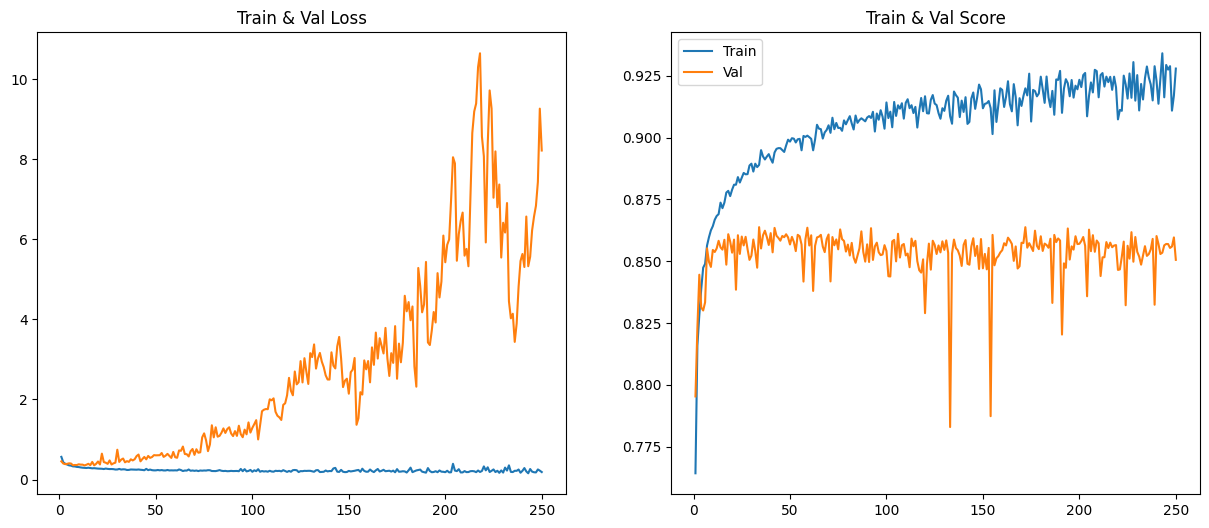

In [165]:
# 시각화

fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,6))
ax1.plot(range(1,EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
ax1.plot(range(1,EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
ax1.set_title('Train & Val Loss')
ax2.plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
ax2.plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
ax2.set_title('Train & Val Score')
plt.legend()
plt.show()